## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
#import ants
import time
import glob
import keras
import imageio
import numpy as np
import random as rd
import seaborn as sns
import tensorflow as tf
from iaflow import IAFlow
from keras import callbacks
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image as PreImage
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten, Cropping2D
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
%matplotlib inline
#import mixed_precision
from tensorflow.keras import mixed_precision

SEED = 42 
rd.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
devices = tf.config.list_physical_devices('GPU')

print("Tensorflow version " + tf.__version__)
print("Gpu is", "available." if devices else "NOT AVAILABLE.", devices)
mixed_precision.set_global_policy('mixed_float16')

Tensorflow version 2.8.0
Gpu is available. [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


## Constants

In [2]:
PREFIX = '.' # /mnt/f/Researh/MRIClassification'
PATH_DATA = f'{PREFIX}/data/mri'
TF_RECORD_PATH = f'{PREFIX}/data/tfrecords/tf_dataset.tfrecord'

SHAPE = (197, 233, 189)
TG_ID = os.environ.get('TG_ID')
TG_TOKEN = os.environ.get('TG_TOKEN')
WEBHOOK_URL = os.environ.get('WEBHOOK_URL')

classes = { 'PD': 1, 'Eat': 0, 'Sex': 2, 'Buy': 3, 'Gamble': 4 }
SKIP_CLASS = [ 'Sex', 'Buy', 'Gamble' ]

## Utils functions

In [9]:
def get_random_image(class_name):
  path_class = f'{PATH_DATA}/{class_name}/raw'
  files = os.listdir(path_class)
  file = files[np.random.randint(len(files))]
  return file, ants.image_read(f'{PATH_DATA}/{class_name}/raw/{file}')

def create_file_list(path_csv_paths, path_classes):
  mri_list = []
  print('Creating list of paths')

  folders = os.listdir(path_classes)
  for class_folder in folders:

    if class_folder in SKIP_CLASS:
      continue
    
    for filename in os.listdir(f'{path_classes}/{class_folder}/raw'):
      file_path = f'{path_classes}/{class_folder}/raw/{filename}'
      label_class = classes.get(class_folder.strip())
      if label_class is None:
        print(f'Class {class_folder} not found', label_class)
        raise Exception('Not label found')
      mri_list.append((file_path, label_class))

  for idx in range(SEED * 100):
    np.random.shuffle(mri_list)

  print('Saving list to CSV')
  with open(path_csv_paths, 'w') as f:
    for item in mri_list:
      f.write(f'{item[0]},{item[1]}\n')

  return mri_list

def create_example(filename, label):
  imag_ants = ants.image_read(filename).numpy()
  imag_ants = (imag_ants - imag_ants.min()) / (imag_ants.max() - imag_ants.min())
  imag_ants = np.reshape(imag_ants, SHAPE)

  return tf.train.Example(features=tf.train.Features(feature={
    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[imag_ants.tobytes()])),
    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
  })).SerializeToString()

def create_tfrecord(path_classes, tfrecord_path):
  path_csv_paths = f'{PREFIX}/data/mri_list.csv'
  
  if os.path.exists(path_csv_paths):
    response = input('The file for CSV paths already exists, do you want to overwrite it? [y/n]: ')
    if response == 'y':
      mri_list = create_file_list(path_csv_paths, path_classes)
    else:
      with open(path_csv_paths, 'r') as f:
        mri_list = [ line.strip().split(',') for line in f.readlines() ]

  if os.path.exists(tfrecord_path):
    response = input('The file already exists, do you want to overwrite it? [y/n]: ')
    if response == 'y':
      os.remove(tfrecord_path)
    else:
      return

  print(f'Creating {tfrecord_path} with {len(mri_list)} images')
  writer = tf.io.TFRecordWriter(tfrecord_path)

  for idx, (filename, label) in enumerate(mri_list):
    writer.write(create_example(filename, label))
    if idx % 10 == 0 or idx == (len(mri_list) - 1):
      print(f'Processed {idx + 1} images of {len(mri_list)}. {(idx + 1) / len(mri_list) * 100:.2f}%. {time.strftime("%H:%M:%S")}')

  writer.close()

def parse_example(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, features)
  image = tf.io.decode_raw(example['image'], tf.float32)
  image = tf.reshape(image, SHAPE)
  image = tf.reshape(image, (SHAPE[0], SHAPE[1], SHAPE[2]))
  #one_hot = tf.one_hot(example['label'], 2)
  return image, example['label']

def load_tfrecord(tfrecord_path):
  dataset = tf.data.TFRecordDataset(tfrecord_path)
  dataset = dataset.map(parse_example)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  #dataset = dataset.cache()
  return dataset

def model_builder(**kwargs):
  model_type = kwargs['model_type']
  model = None
  if model_type == 'vit':
    kwargs.pop('model_type')
    model = VitNet(**kwargs)
  elif model_type == 'vitNet_direct':
    kwargs.pop('model_type')
    model = VitNetDirect(**kwargs)
  else:
    raise ValueError('Model type not found')

  return model


## Dataset

In [4]:
#create_tfrecord(PATH_DATA, TF_RECORD_PATH)

In [10]:
tf_dataset = load_tfrecord(TF_RECORD_PATH)

In [11]:
all_items = 1386

train_size = int(all_items * 0.8)
val_size = int(all_items - train_size)

train_dataset = tf_dataset.take(train_size)
val_dataset = tf_dataset.skip(train_size)

print(f'Train size: {train_size}, val size: {val_size}')

Train size: 1108, val size: 278


## Model

In [3]:
def create_model():
  main_input = Input(shape=(197, 233, 189, 1),dtype='float32',name='main_input')
  First_input_C1 = Conv3D(padding="same",activation='relu',filters=16, kernel_size=(3, 3, 3))(main_input)
  First_input_C1_Batch = BatchNormalization(axis=4)(First_input_C1)
  First_Pooling = MaxPool3D(pool_size=(2,2,2))(First_input_C1_Batch)
  First_input_C2 = Conv3D(padding="same",activation='relu',filters=16, kernel_size=(3, 3, 3))(First_Pooling)
  First_input_C2_Batch = BatchNormalization(axis=4)(First_input_C2)
  First_input_C3 = Conv3D(padding="same",activation='relu',filters=16, kernel_size=(3, 3, 3))(First_input_C2_Batch)
  First_input_C3_Batch = BatchNormalization(axis=4)(First_input_C3)
  Dropout_layer_1 = Dropout(0.3)(First_input_C3_Batch)

  CNN_C6 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_1)
  CNN_C6_Batch = BatchNormalization(axis=4)(CNN_C6)

  CNN_C7 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C6_Batch)
  CNN_C7_Batch = BatchNormalization(axis=4)(CNN_C7)
  # Dropout_layer_2 = Dropout(0.35)(CNN_C7_Batch)
  CNN_C8 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C7_Batch)
  CNN_C8_Batch = BatchNormalization(axis=4)(CNN_C8)
  layer_Addition_1 = Add()([CNN_C8_Batch,CNN_C6_Batch])
  # CNN_Pooling_1 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_1)

  CNN_C74 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_1)
  CNN_C74_Batch = BatchNormalization(axis=4)(CNN_C74)
  # Dropout_layer_2 = Dropout(0.35)(CNN_C7_Batch)
  CNN_C84 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C74_Batch)
  CNN_C84_Batch = BatchNormalization(axis=4)(CNN_C84)
  layer_Addition_14 = Add()([CNN_C84_Batch,layer_Addition_1])
  # CNN_Pooling_1 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_1)

  CNN_C73 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_14)
  CNN_C73_Batch = BatchNormalization(axis=4)(CNN_C73)
  Dropout_layer_23 = Dropout(0.35)(CNN_C73_Batch)
  CNN_C83 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_23)
  CNN_C83_Batch = BatchNormalization(axis=4)(CNN_C83)
  layer_Addition_13 = Add()([CNN_C83_Batch,layer_Addition_14])
  CNN_Pooling_1 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_13)

  CNN_C9 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_Pooling_1)
  CNN_C9_Batch = BatchNormalization(axis=4)(CNN_C9)
  # Dropout_layer_3 = Dropout(0.40)(CNN_C9_Batch)
  CNN_C10 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C9_Batch)
  CNN_C10_Batch = BatchNormalization(axis=4)(CNN_C10)
  layer_Addition_2 = Add()([CNN_C10_Batch,CNN_Pooling_1])
  # CNN_Pooling_2 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_2)

  CNN_C93 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_2)
  CNN_C93_Batch = BatchNormalization(axis=4)(CNN_C93)
  # Dropout_layer_3 = Dropout(0.40)(CNN_C9_Batch)
  CNN_C103 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C93_Batch)
  CNN_C103_Batch = BatchNormalization(axis=4)(CNN_C103)
  layer_Addition_23 = Add()([CNN_C103_Batch,layer_Addition_2])
  # CNN_Pooling_2 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_2)

  CNN_C92 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_23)
  CNN_C92_Batch = BatchNormalization(axis=4)(CNN_C92)
  Dropout_layer_32 = Dropout(0.40)(CNN_C92_Batch)
  CNN_C102 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_32)
  CNN_C102_Batch = BatchNormalization(axis=4)(CNN_C102)
  layer_Addition_22 = Add()([CNN_C102_Batch,layer_Addition_23])
  CNN_Pooling_2 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_22)
  
  CNN_C91 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_Pooling_2)
  CNN_C91_Batch = BatchNormalization(axis=4)(CNN_C91)

  CNN_C11 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C91_Batch)
  CNN_C11_Batch = BatchNormalization(axis=4)(CNN_C11)
  # Dropout_layer_4 = Dropout(0.45)(CNN_C11_Batch)
  CNN_C12 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C11_Batch)
  CNN_C12_Batch = BatchNormalization(axis=4)(CNN_C12)
  layer_Addition_3 = Add()([CNN_C12_Batch,CNN_C91_Batch])
  # CNN_Pooling_3 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_3)
  
  CNN_C911 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_3)
  CNN_C911_Batch = BatchNormalization(axis=4)(CNN_C911)

  CNN_C111 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C911_Batch)
  CNN_C111_Batch = BatchNormalization(axis=4)(CNN_C111)
  # Dropout_layer_41 = Dropout(0.45)(CNN_C111_Batch)
  CNN_C121 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C111_Batch)
  CNN_C121_Batch = BatchNormalization(axis=4)(CNN_C121)
  layer_Addition_31 = Add()([CNN_C121_Batch,CNN_C911_Batch])
  # CNN_Pooling_3 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_31)
  
  CNN_C9111 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_31)
  CNN_C9111_Batch = BatchNormalization(axis=4)(CNN_C9111)

  CNN_C1111 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C9111_Batch)
  CNN_C1111_Batch = BatchNormalization(axis=4)(CNN_C1111)
  Dropout_layer_411 = Dropout(0.45)(CNN_C1111_Batch)
  CNN_C1211 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_411)
  CNN_C1211_Batch = BatchNormalization(axis=4)(CNN_C1211)
  layer_Addition_311 = Add()([CNN_C1211_Batch,CNN_C9111_Batch])
  CNN_Pooling_3 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_311)

  flatten_layer = Flatten()(CNN_Pooling_3)
  dense_layer_1 = Dense(units=100,activation="relu")(flatten_layer)
  Dropout_layer_5 = Dropout(0.20)(dense_layer_1)
  dense_layer_2 = Dense(units=50,activation="relu")(Dropout_layer_5)
  output_layer = Dense(units=2,activation="softmax")(dense_layer_2)

  Tri_dim_model = Model(inputs=[main_input],outputs=[output_layer])

  return Tri_dim_model

from tensorflow.python.ops.gen_math_ops import xdivy

class MLP(layers.Layer):
  def __init__(self, hidden_units=[128, 64], dropout_rate=0.1, activation="gelu", **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dropout_rate = dropout_rate
    self.hidden_units = hidden_units
    self.activation = activation
    for i, units in enumerate(hidden_units):
      setattr(self, f'dense_{i}', layers.Dense(units, activation=self.activation))
      setattr(self, f'dropout_{i}', layers.Dropout(dropout_rate))

  def get_config(self, **kwargs):
    config = super().get_config()
    config_dict = {
        "dropout_rate": self.dropout_rate,
        "hidden_units": self.hidden_units,
        "activation": self.activation
    }
    config.update(config_dict)
    return config

  def call(self, x, training=None, **kwargs):
    for i, _ in enumerate(self.hidden_units):
      x = getattr(self, f'dense_{i}')(x)
      x = getattr(self, f'dropout_{i}')(x, training=training)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self, **kwargs):
      config = super().get_config()
      config_dict = {
          "patch_size": self.patch_size
      }
      config.update(config_dict)
      return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim=64, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=self.projection_dim
        )

    def get_config(self):
      config = super().get_config()
      config_dict = {
          "num_patches": self.num_patches,
          "projection_dim": self.projection_dim
      }

      config.update(config_dict)
      return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# baseline 6
def VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  inter_outputs = []

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

    if i % 3 == 0 or i == (transformer_layers - 1):
      inter_outputs.append(patch_encoder)

  cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(cont)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP([ 128 ], 0.1, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, activation='softmax', name='output')(flatten)

  model = Model(inputs=inputs, outputs = outputs)
  return model

def VitNetDirect(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(patch_encoder)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP([ 128 ], 0.1, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, name='output')(flatten)

  model = Model(inputs=inputs, outputs=outputs)
  return model

# baseline
def VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  inter_outputs = []

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

    if i % 3 == 0 or i == (transformer_layers - 1):
      inter_outputs.append(patch_encoder)

  cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(cont)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP(mlp_class, drop_class, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, activation='softmax', name='output')(flatten)

  model = Model(inputs=inputs, outputs = outputs)
  return model


## Training

In [8]:
BATCH_SIZE = 32
patch_size = 10
projection_dim = 64
num_patches = (SHAPE[0] // patch_size) ** 2

vit_params_baseline = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 32 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'use_aug': False, 'ds_slices': False,
  'transformer_layers': 9, 'patch_size': patch_size, 'conv_front': True,
  'num_patches': num_patches, 'projection_dim': projection_dim,
  'num_heads': 4, 'transformer_units': [ projection_dim * 2, projection_dim ] , 'dropout_rate': 0.1
}

vit_params_mlp_1 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 12, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': projection_dim,
  'num_heads': 4, 'transformer_units': [ projection_dim * 2, projection_dim ] , 'dropout_rate': 0.1
}

vit_params_mlp_2 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 12, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 128,
  'num_heads': 4, 'transformer_units': [ 128 * 2, 128 ] , 'dropout_rate': 0.1
}

vit_params_mlp_3 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.25,
  'transformer_layers': 12, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 128,
  'num_heads': 4, 'transformer_units': [ 128 * 2, 128 ] , 'dropout_rate': 0.1
}

In [9]:
ia_maker = IAFlow(
  models_folder='./models',
  builder_function=model_builder,
  checkpoint_params={
    'save_weights_only': False,
    'save_best_only': True,
    'monitor': 'val_loss',
    'verbose': 1
  },
  tensorboard_params={
    'histogram_freq': 1
  },
  params_notifier = {
    'title': 'Training update',
    'frequency_epoch': 5,
    'api_token': TG_TOKEN,
    'chat_id': TG_ID
  },
  callbacks=[
    ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
  ]
)

ia_maker.add_dataset(
  name='2_classes',
  epochs=100,
  batch_size=BATCH_SIZE,
  train_ds=train_dataset,
  val_ds=val_dataset,
)

vit_baseline = ia_maker.add_model(
  model_name='vit',
  run_id='baseline',
  model_params=vit_params_baseline,
  load_model_params={
    'custom_objects': {
      'MLP': MLP,
      'Patches': Patches,
      'PatchEncoder': PatchEncoder,
    }
  },
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_baseline.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
  }
)

vit_mlp_1 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_1',
  model_params=vit_params_mlp_1,
  load_model_params={
    'custom_objects': {
      'MLP': MLP,
      'Patches': Patches,
      'PatchEncoder': PatchEncoder,
    }
  },
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_1.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
  }
)

vit_mlp_2 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_2',
  model_params=vit_params_mlp_2,
  load_model_params={
    'custom_objects': {
      'MLP': MLP,
      'Patches': Patches,
      'PatchEncoder': PatchEncoder,
    }
  },
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_2.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
  }
)

vit_mlp_3 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_3',
  model_params=vit_params_mlp_3,
  load_model_params={
    'custom_objects': {
      'MLP': MLP,
      'Patches': Patches,
      'PatchEncoder': PatchEncoder,
    }
  },
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_3.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
  }
)


GPU info: GPU connected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dataset 2_classes was added
Model vit/baseline was added
Model vit/mlp_1 was added
Model vit/mlp_2 was added
Model vit/mlp_3 was added


In [ ]:
ia_maker.train(
  epochs=60,
  initial_epoch=0,
  model_data=vit_mlp_3,
  dataset_name='2_classes',
  force_creation=True
)

In [10]:
ia_maker.clear_session()

## Evaluate models

In [10]:
CLASSES_NUM = 2
BATCH_SIZE_EVA = 4
skip_models = ['baseline', 'mlp_1'] #'baseline', 'mlp_1', 'mlp_2'

Loading model from ./models\vit\mlp_2/vit_vit_(197, 233, 189)_[128]_0.0001_32_0.1_12_10_361_128_4_[256, 128]_0.1_checkpoint.h5
Predicting vit/mlp_2
Predicting done, with accuracy:  0.8201439


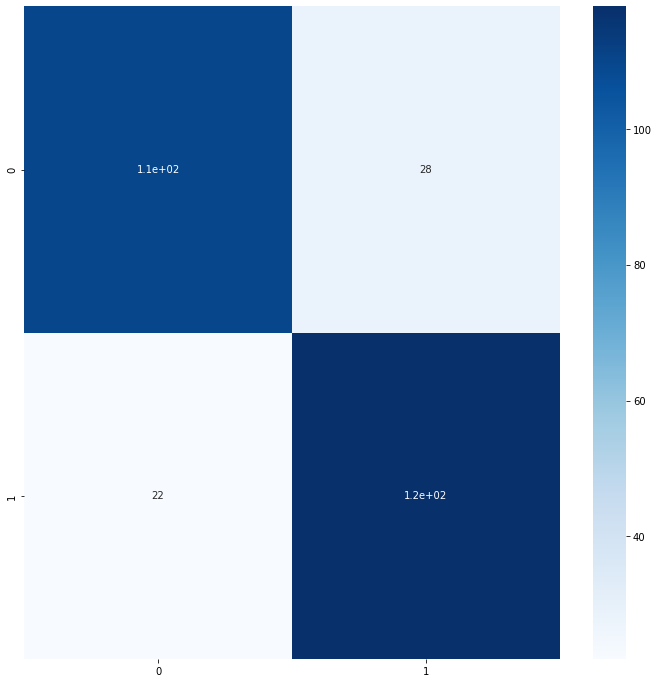

Loading model from ./models\vit\mlp_3/vit_vit_(197, 233, 189)_[128]_0.0001_32_0.25_12_10_361_128_4_[256, 128]_0.1_checkpoint.h5
Predicting vit/mlp_3
Predicting done, with accuracy:  0.823741


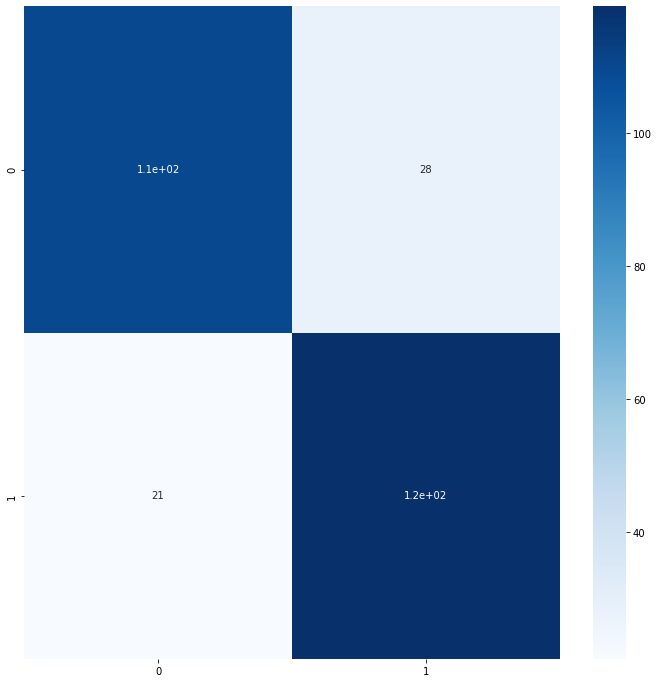

In [11]:
for model_name in os.listdir('./models/'):
  for run_id in os.listdir(f'./models/{model_name}'):
    if run_id in skip_models:
      continue

    ia_maker.clear_session()
    result = ia_maker.get_model(model_name, run_id, False)
    if result is None or run_id in skip_models:
      continue

    model, run_id_data = result
    model_folder = run_id_data.get('path_model')
    metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

    all_preds = []
    all_labels = []
    print(f'Predicting {model_name}/{run_id}')
    for images, label in val_dataset.batch(BATCH_SIZE_EVA):
      preds = model.predict(images)
      metric.update_state(label, preds)
      all_labels.extend(label.numpy())
      all_preds.extend(np.argmax(preds, axis=1))
    model = None
    metric_result = metric.result().numpy()
    print('Predicting done, with accuracy: ', metric_result)
    metric.reset_states()
    ia_maker.clear_session()
    
    confusion_matrix= tf.math.confusion_matrix(all_labels, all_preds, num_classes=CLASSES_NUM)
    plt.figure(figsize=(12, 12))
    sns.heatmap(confusion_matrix.numpy(), annot=True, cmap='Blues')
    plt.savefig(f'{model_folder}/confusion_matrix_test_{metric_result}.png')
    plt.show()

# Grad cam

In [5]:
import tensorflow as tf

model = tf.keras.models.load_model(
  './models/vit/mlp_3/vit_vit_(197, 233, 189)_[128]_0.0001_32_0.25_12_10_361_128_4_[256, 128]_0.1_checkpoint.h5',
  custom_objects={
    'MLP': MLP,
    'Patches': Patches,
    'PatchEncoder': PatchEncoder,
  }
)

In [65]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
  with tf.GradientTape(persistent=True) as tape:
    preds, swin_top = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

  grads = tape.gradient(class_channel, swin_top)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  swin_top = swin_top[0]
  heatmap_b = swin_top @ pooled_grads[..., tf.newaxis]
  heatmap_b = tf.squeeze(heatmap_b)
  heatmap_b = tf.maximum(heatmap_b, 0) / tf.math.reduce_max(heatmap_b)
  heatmap_b = heatmap_b.numpy()
  return heatmap_b

def plot_stuff(inputs, features_a):
  plt.figure(figsize=(25, 25))
  
  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.imshow(inputs)
  plt.title('Input')
  
  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.imshow(features_a)
  plt.title('Gradcam')

def create_grad_model(model, layer_name):
  grad_model = tf.keras.Model(
    [ model.inputs ],
    [ model.output, model.get_layer(layer_name).output ]
  )
  return grad_model

In [71]:
grad_model = create_grad_model(model, 'conv2d') # patch_encoder_1 

In [28]:
val_numpy = val_dataset.as_numpy_iterator()
input_mri = val_numpy.next()

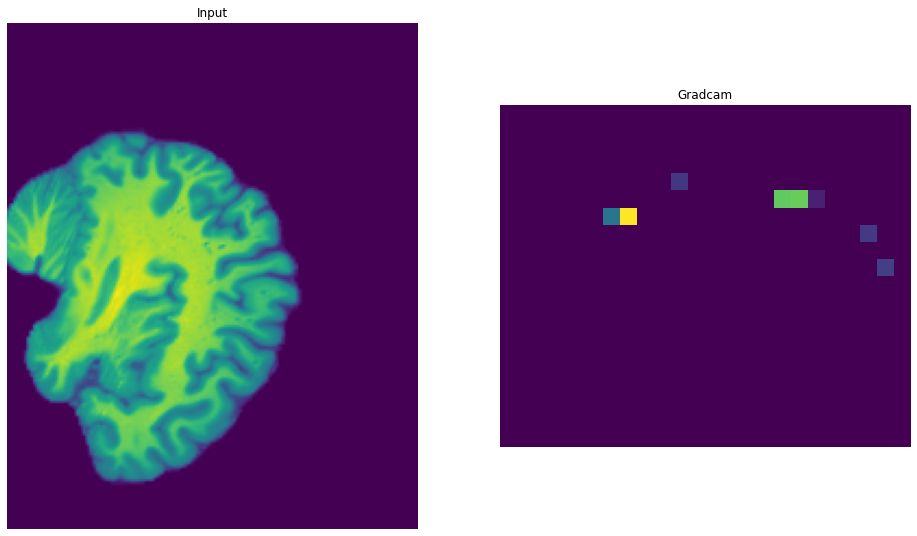

In [72]:
heatmap = make_gradcam_heatmap(
  tf.expand_dims(input_mri[0], axis=0),
  grad_model
)

plot_stuff(input_mri[0][80], heatmap)

In [12]:
tf.expand_dims(tf.cast(val_dataset.take(1).as_numpy_iterator().next()[0][0], tf.float32), axis=0)

<tf.Tensor: shape=(1, 233, 189), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [15]:
a = val_dataset.take(1).as_numpy_iterator().next()

In [23]:
a[0].shape

(197, 233, 189)

In [17]:
tf.expand_dims(tf.cast(a[0], tf.float32), axis=0)

<tf.Tensor: shape=(1, 197, 233, 189), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+0